# Bostrom supply simulation

---

## Rationale

There are three network tokens:

* T - liquid network token
* V - vested network token
* F - not claimed(frozen) network token

and two energy tokens:

* Am - Amper token
* Vo - Volt token

The initial state of all tokens should be defined below

* 1 **timestep** == 1 network block

## Claim function

The function of claim frozen tokens is:

\begin{gather}
\\
f(x) = -2.9 \cdot 10^7x + 7 \cdot 10^{14} \\
\\
\end{gather}

![](./images/claim.png)

where **x** is network block. This function means 80% of frozen tokens are going to be claimed in 3 years linearly by 29,000,000 tokens per block.

## Vesting and Unvesting

The vesting function is defined as the number of blocks in months for vesting all liquid tokens. This function recalculates every block.

The vesting function is defined as the number of blocks in months for investing all vested tokens. This function recalculates every block.

## Energy tokens

Amperes and Volts mints by the following formula:

\begin{gather}
\\
f(x) = \frac{x \cdot * lockTime/cycle}{1000000} \cdot MR \\
\\
\end{gather}

where: 
* **x** is number of vested tokens
* **lockTime** is time fot locking tokens
* **cycle** is amount of blocks for rank and entropy calculation
* **MR** is mint rate [100, 0)

## Mint Rate

Mint rate is multiple coefficient for minting energy tokens

|A|B|
|:---:|:---:|
|\begin{gather}
\\
MR_A(x) = 100 \cdot e^{-6.93147 \cdot 10^{-16}x} \\
\\
\end{gather}|\begin{gather}
\\
MR_B(x) = 100 - \frac{11x}{4908960} \\
\\
\end{gather}|
|**x** is energy token supply| **x** is network block|
|![](./images/MR_A.png)|![](./images/MR_B.png)|
|This function provides a double decrease of MR  every 10^15 energy tokens supply| This function provides a linearly decrease of MR from 100 to 1 in 7 years (44,180,640 blocks)|


## Inflation

The inflation function depends on the ratio between vested tokens and tokens supply. It the same as in cosmos-based networks. 

## Supply

Supply is the sum of liquid, vested and frozen tokens in each block.

## Assumptions

1. All agents lock tokens for the maximum available period defined in params for simulating
2. All agents mint maximum **Am** and **Vo** tokens in 50/50 ratio

## Initial state

In [1]:
tokens = 200_000_000_000_000 # Unfreeze and unvested liquid network tokens
frozen = 700_000_000_000_000 # Waiting for claim liquid network tokens
vested = 100_000_000_000_000 # Vested tokens according to genesis ceremony
init_inflation = 0.01        # Start inflation

## Params for simulating

In [2]:
inflation_rate_change = [0.13] # maximum inflation rate change per year
inflation_min = [0.01]         # minimum percent of the inflation
inflation_max = [0.15]         # minimum percent of the inflation
goal_vested = [0.88]           # desireable ratio between vested tokens and tokens supply
blocks_per_year = [6_311_520]  # desireable amount of blocks per year
max_vesting_time = [1_577_880] # max amount of blocks for locking
vesting_speed = [2]            # amount of months to vest all liquid tokens
unvesting_speed = [60]         # amount of months to uninvest all vested tokens 
cycle = [5]                    # amount of blocks for rank and entropy recalculating

sim_period = 12 * 2            # amount of months for simulating

## Mathematical Specification

### Differential Equations

* T - liquid network token
* V - vested network token
* F - not claimed(frozen) network token
* IRC_b - inflation rate change per block
* S - total network tokens supply
* I - inflation per block in network tokens
* BlockProvision - per block token provision
* Am - Amper token
* Vo - Volt token

\begin{gather}
\\
T_b = T_{b-1} + {\Delta T} \tag{1} \\
V_b = V_{b-1} + {\Delta V} \tag{2} \\
F_b = F_{b-1} + {\Delta F} \tag{3} \\
Am_b = Am_{b-1} + {\Delta Am} \tag{4} \\
Vo_b = Vo_{b-1} + {\Delta Vo} \tag{5} \\
MR_{b}^A = {\Delta MR^A} \tag{6} \\
MR_{b}^B = MR_{b-1}^B+ {\Delta MR^B} \tag{7} \\
S_b = T_b + V_b + F_b \tag{8} \\ 
\\
\end{gather}

where the rate of change ($\Delta$) is:
\begin{gather}
\\
{\Delta F} = -29000000 \tag{9} \\ \\
{\Delta V} = \frac{T_{b-1}}{(blocksPerYear*(1/12 \cdot vestingSpeed)} - {\Delta U} \tag{10} \\ \\
{\Delta T} = - {\Delta F} - {\Delta V} + I_{b-1} + {\Delta U}  \tag{11} \\ \\
{\Delta Am} = \frac{{\Delta V} * \frac{maxVestingTime}{cycle}}{2 * 1000000} \cdot MR  \tag{12} \\ \\
{\Delta Vo} = \frac{{\Delta V} * \frac{maxVestingTime}{cycle}}{2 * 1000000} \cdot MR  \tag{13} \\ \\
{\Delta U} = \frac{V_{b-1}}{(blocksPerYear*(1/12 \cdot unvestingSpeed)} \tag{14} \\ \\
{\Delta MR^A} = 100 \cdot e^{-6.93147 \cdot 10^{-16}x} \tag{15} \\ \\
{\Delta MR^B} = - \frac{11}{4908960} \tag{16} \\ \\
\\
\end{gather}

where:
\begin{gather}
\\
I_{b-1} = \frac{S_{b-1} \cdot IRC_{b-1}}{blocksPerYear} \tag{17} \\ \\
IRC_b = \frac{\left(1 - \frac{vestedRatio_{b-1}}{goalVested}\right) \cdot inflationRateChange}{blocksPerYear} \tag{18} \\
\\
\end{gather}

In [3]:
import time

# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
# import plotly

In [4]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from collections import Counter
from cadCAD import configs

In [5]:
initial_state = {
    'T':   tokens,
    'F':   frozen,
    'V':   vested,
    'Am': 0,
    'Vo': 0,
    'd_u': 0,
    'I_r': init_inflation,
    'd_v': 0,
    'MR': 100
}

system_params = {
    'inflationRateChange': inflation_rate_change,
    'inflationMin': inflation_min,
    'inflationMax': inflation_max,
    'goalVested': goal_vested,
    'blocksPerYear': blocks_per_year,
    'maxVestingTime': max_vesting_time,
    'vestingSpeed': vesting_speed,
    'unvestingSpeed': unvesting_speed,
    'cycle': cycle
}

Adapting to use **policy functions** to drive the process, and **state update functions** to update the state according to the **differential specification**:

In [6]:
def p_inflation(params, substep, state_history, previous_state):
    S = previous_state['T'] + previous_state['F'] + previous_state['V']
    V_r = previous_state['V']/S
    IRC = (1 - (V_r/params['goalVested'])) * params['inflationRateChange']
    IRC = IRC / params['blocksPerYear']
    return {'IRC': IRC}

def p_blockProvision(params, substep, state_history, previous_state):
    S = previous_state['T'] + previous_state['F'] + previous_state['V']
    V_r = previous_state['V'] / S
    IRC = ((1 - V_r/params['goalVested']) * params['inflationRateChange']) / params['blocksPerYear']
    I_r = previous_state['I_r'] + IRC
    if I_r > params['inflationMax']:
        I_r = params['inflationMax']
    elif I_r < params['inflationMin']:
        I_r = params['inflationMin']
    I_p = (S * I_r) / params['blocksPerYear']
    return {'block_provision': math.ceil(I_p)}

def p_claim(params, substep, state_history, previous_state):
    delta_f = -29_000_000
    if previous_state['F'] <= 0:
        delta_f = 0
    return {'delta_F': delta_f}

def p_vest(params, substep, state_history, previous_state):
    investmint = previous_state['T']/(params['blocksPerYear'] * ((1/12) * params['vestingSpeed']))
    return {'delta_V': math.ceil(investmint)}

def p_unvest(params, substep, state_history, previous_state):
    if previous_state['timestep'] <= params['maxVestingTime']:
        uninvestmint = 0
    else:
        uninvestmint = previous_state['V']/(params['blocksPerYear'] * ((1/12) * params['unvestingSpeed']))
    return {'delta_U': math.ceil(uninvestmint)}

def p_mr_a(params, substep, state_history, previous_state):
    d_mr = 100 * math.exp(-6.93147 * 10**(-16) * previous_state['Am'])
    return {'delta_MR': d_mr}

def p_mr_b(params, substep, state_history, previous_state):
    d_mr = -11/4908960
    return {'delta_MR': d_mr}

In [7]:
def s_I_r(params, substep, state_history, previous_state, policy_input):
    I_r = previous_state['I_r'] + policy_input['IRC']
    if I_r > params['inflationMax']:
        I_r = params['inflationMax']
    elif I_r < params['inflationMin']:
        I_r = params['inflationMin']
    return 'I_r', I_r

def s_F(params, substep, state_history, previous_state, policy_input):
    F = previous_state['F'] + policy_input['delta_F']
    if F < 0:
        F = 0
    return 'F', F

def s_V(params, substep, state_history, previous_state, policy_input):
    V = previous_state['V'] + policy_input['delta_V'] - policy_input['delta_U']
    return 'V', V

def s_T(params, substep, state_history, previous_state, policy_input):
    T = previous_state['T'] - policy_input['delta_F'] - policy_input['delta_V'] + policy_input['block_provision'] + policy_input['delta_U']
    return 'T', T

def s_d_u(params, substep, state_history, previous_state, policy_input):
    return 'd_u', policy_input['delta_U']

def s_d_v(params, substep, state_history, previous_state, policy_input):
    return 'd_v', policy_input['delta_V']

def s_am(params, substep, state_history, previous_state, policy_input):
    am = previous_state['Am'] + ((policy_input['delta_V'] * (params['maxVestingTime']/params['cycle'])) / 2_000_000) * (previous_state['MR']/100)
    return 'Am', am

def s_vo(params, substep, state_history, previous_state, policy_input):
    vo = previous_state['Vo'] + ((policy_input['delta_V'] * (params['maxVestingTime']/params['cycle'])) / 2_000_000) * (previous_state['MR']/100)
    return 'Vo', vo

def s_mr_a(params, substep, state_history, previous_state, policy_input):
    mr = policy_input['delta_MR']
    return 'MR', mr

def s_mr_b(params, substep, state_history, previous_state, policy_input):
    mr = previous_state['MR'] + policy_input['delta_MR']
    if mr < 1:
        mr = 1
    return 'MR', mr
    

In [8]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil((6311520/12) * sim_period))),
    'M': system_params
})

In [9]:
partial_state_update_blocks = [
    {
        'policies': {
            'IRC': p_inflation,
            'block_provision': p_blockProvision, 
            'delta_F': p_claim, 
            'delta_V': p_vest,
            'delta_U': p_unvest,
            'delta_MR': p_mr_a
        },
        'variables': {
            'I_r': s_I_r,
            'F': s_F,
            'V': s_V,
            'T': s_T,
            'd_u': s_d_u,
            'd_v': s_d_v,
            'Am': s_am,
            'Vo': s_vo,
            'MR': s_mr_a
        }
    }
]

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [10]:
partial_state_update_blocks = [
    {
        'policies': {
            'IRC': p_inflation,
            'block_provision': p_blockProvision, 
            'delta_F': p_claim, 
            'delta_V': p_vest,
            'delta_U': p_unvest,
            'delta_MR': p_mr_b
        },
        'variables': {
            'I_r': s_I_r,
            'F': s_F,
            'V': s_V,
            'T': s_T,
            'd_u': s_d_u,
            'd_v': s_d_v,
            'Am': s_am,
            'Vo': s_vo,
            'MR': s_mr_b
        }
    }
]

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [11]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (12623040, 9, 1, 9)
Execution Method: local_simulations
SimIDs   : [0, 1]
SubsetIDs: [0, 0]
Ns       : [0, 0]
ExpIDs   : [0, 1]
Execution Mode: parallelized
Total execution time: 1637.05s


In [12]:
start_time = time.time()
simulation_result = pd.DataFrame(raw_result)
print("--- %s seconds ---" % (time.time() - start_time))

--- 653.4530627727509 seconds ---


In [13]:
start_time = time.time()

In [14]:
df = simulation_result.copy()
df['Supply'] = df['T'] + df['F'] + df['V']
df['AmPrice'] = df['Am'] / df['Supply']
df['ratio'] = df['V']/df['Supply']
df

,T,F,V,Am,Vo,d_u,I_r,d_v,MR,simulation,subset,run,substep,timestep,Supply,AmPrice,ratio
0,200000000000000,700000000000000,100000000000000,0.000000e+00,0.000000e+00,0,0.010000,0,100.000000,0,0,1,0,0,1000000000000000,0.000000e+00,0.100000
1,199999840455881,699999971000000,100000190128527,3.000000e+07,3.000000e+07,0,0.010000,190128527,100.000000,0,0,1,1,1,1000000001584408,3.000000e-08,0.100000
2,199999680911916,699999942000000,100000380256903,5.999998e+07,5.999998e+07,0,0.010000,190128376,99.999998,0,0,1,1,2,1000000003168819,5.999998e-08,0.100000
3,199999521368106,699999913000000,100000570385127,8.999993e+07,8.999993e+07,0,0.010000,190128224,99.999996,0,0,1,1,3,1000000004753233,8.999993e-08,0.100001
4,199999361824450,699999884000000,100000760513199,1.199999e+08,1.199999e+08,0,0.010000,190128072,99.999994,0,0,1,1,4,1000000006337649,1.199999e-07,0.100001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25246077,80254728393371,333931956000000,773168257710093,1.167062e+14,1.167062e+14,24500223,0.139177,76293564,71.714295,1,0,1,1,12623036,1187354942103464,9.829088e-02,0.651169
25246078,80254731782632,333931927000000,773168309503436,1.167062e+14,1.167062e+14,24500224,0.139177,76293567,71.714292,1,0,1,1,12623037,1187354968286068,9.829088e-02,0.651169
25246079,80254735171893,333931898000000,773168361296780,1.167062e+14,1.167062e+14,24500226,0.139177,76293570,71.714290,1,0,1,1,12623038,1187354994468673,9.829089e-02,0.651169
25246080,80254738561154,333931869000000,773168413090126,1.167062e+14,1.167062e+14,24500227,0.139177,76293573,71.714288,1,0,1,1,12623039,1187355020651280,9.829090e-02,0.651169


In [15]:
df_a = df[df.simulation==0]
df_b = df[df.simulation==1]
start_time = time.time()

## Inflation

<AxesSubplot:xlabel='timestep'>

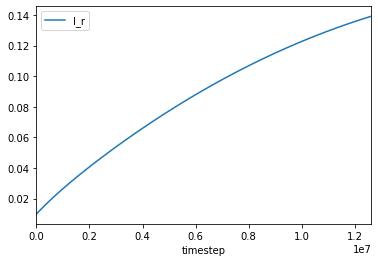

In [16]:
df[df.simulation == 0].plot(kind='line', x='timestep', y=['I_r'])

## Supply, liquid, frozen and vested tokens

<AxesSubplot:xlabel='timestep'>

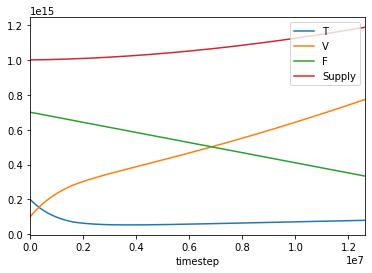

In [17]:
df[df.simulation==0].plot(kind='line', x='timestep', y=['T','V', 'F', 'Supply'])

## Increment of vested and unvested tokens

<AxesSubplot:xlabel='timestep'>

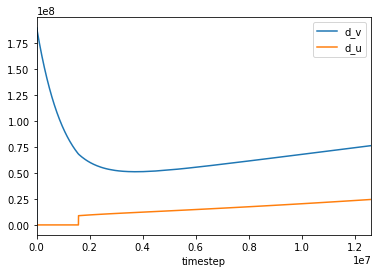

In [18]:
df[df.simulation == 0].plot(kind='line', x='timestep', y=['d_v', 'd_u'])

## Vested ratio

<AxesSubplot:xlabel='timestep'>

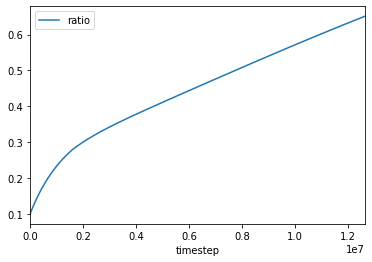

In [19]:
df[df.simulation == 0].plot(kind='line', x='timestep', y=['ratio'])

## Amper(volt) tokens supply

<AxesSubplot:xlabel='timestep'>

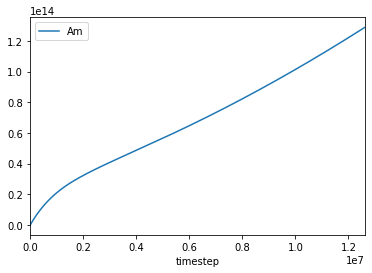

In [20]:
df_a.plot(kind='line', x='timestep', y=['Am'])

<AxesSubplot:xlabel='timestep'>

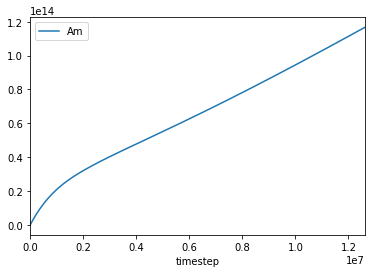

In [21]:
df_b.plot(kind='line', x='timestep', y=['Am'])

## Mint Rate

<AxesSubplot:xlabel='timestep'>

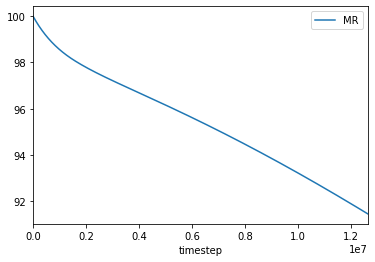

In [22]:
df_a.plot(kind='line', x='timestep', y=['MR'])

<AxesSubplot:xlabel='timestep'>

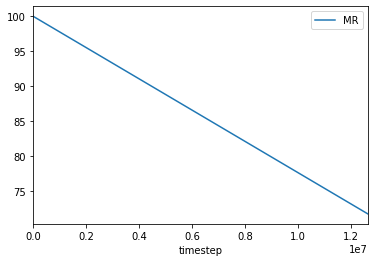

In [23]:
df_b.plot(kind='line', x='timestep', y=['MR'])

## Ratio between amper(volt) supply and tokens supply

<AxesSubplot:xlabel='timestep'>

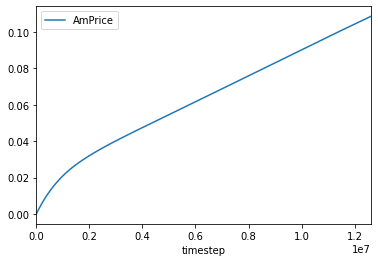

In [24]:
df_a.plot(kind='line', x='timestep', y=['AmPrice'])

<AxesSubplot:xlabel='timestep'>

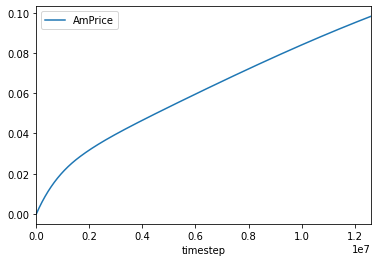

In [25]:
df_b.plot(kind='line', x='timestep', y=['AmPrice'])

In [26]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 382.67803859710693 seconds ---
